In [1]:
hdfs_prefix = "hdfs:///"  
ratings_path = f"{hdfs_prefix}/input/rating.csv"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, count, trim, when, avg, round as spark_round, count as sql_count

In [3]:
spark = SparkSession.builder \
    .appName("Traitement rating") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Read the CSV file
ratings_df = spark.read.csv(ratings_path, header=True, inferSchema=True)
movies_df = spark.read.option("header", True).csv("hdfs:///input/movie.csv")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

In [4]:
ratings_df.show(5)

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows



In [5]:
# Fonction pour vérifier les valeurs nulles/vides adaptée aux types de données
def null_check(column_name, column_type):
    if column_type in ["double", "float"]:
        return count(when(col(column_name).isNull() | 
                         (trim(col(column_name).cast("string")) == "") | 
                         isnan(col(column_name)), column_name))
    else:
        return count(when(col(column_name).isNull() | 
                         (trim(col(column_name).cast("string")) == ""), column_name))

In [6]:
# Obtenir les types de colonnes
column_types = {field.name: field.dataType.simpleString() for field in ratings_df.schema.fields}

# Vérifier les valeurs nulles et vides par colonne en respectant les types
null_counts = ratings_df.select([
    null_check(c, column_types[c]).alias(c) for c in ratings_df.columns
])

print("\nAnalyse des valeurs nulles et vides par colonne:")
null_counts.show()


Analyse des valeurs nulles et vides par colonne:


[Stage 4:==========================================>              (12 + 4) / 16]

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



In [7]:
total_rows = ratings_df.count()
print(f"Nombre total de lignes: {total_rows}")

# Calculer les pourcentages
null_percentages = {}
for column in ratings_df.columns:
    null_count = null_counts.select(column).collect()[0][0]
    null_percentages[column] = (null_count / total_rows) * 100

print("\nPourcentage de valeurs nulles et vides par colonne:")
for column, percentage in null_percentages.items():
    print(f"{column}: {percentage:.2f}%")

Nombre total de lignes: 20000263


[Stage 19:===>                                                    (1 + 15) / 16]


Pourcentage de valeurs nulles et vides par colonne:
userId: 0.00%
movieId: 0.00%
rating: 0.00%
timestamp: 0.00%


In [8]:
# Identifier les duplications
print("\nAnalyse des duplications:")
duplicates = ratings_df.groupBy(ratings_df.columns).count().filter(col("count") > 1)
duplicate_count = duplicates.count()
print(f"Nombre de lignes dupliquées: {duplicate_count}")

if duplicate_count > 0:
    print("Exemples de lignes dupliquées:")
    duplicates.show(5)

# Statistiques descriptives (pour les colonnes numériques)
print("\nStatistiques descriptives:")
ratings_df.describe().show()


Analyse des duplications:


Nombre de lignes dupliquées: 0

Statistiques descriptives:


[Stage 28:=======>                                                (2 + 14) / 16]

+-------+-----------------+-----------------+------------------+
|summary|           userId|          movieId|            rating|
+-------+-----------------+-----------------+------------------+
|  count|         20000263|         20000263|          20000263|
|   mean|69045.87258292554|9041.567330339605|3.5255285642993797|
| stddev| 40038.6266531621|  19789.477445413| 1.051988919294244|
|    min|                1|                1|               0.5|
|    max|           138493|           131262|               5.0|
+-------+-----------------+-----------------+------------------+



In [9]:
# Analyse des donneés sur le nombre de vote par film :

In [10]:
# Afficher le schéma pour confirmer
print("Schéma du DataFrame:")
ratings_df.printSchema()

# Grouper par movieId et compter le nombre de votes
movie_votes = ratings_df.groupBy("movieId").count().withColumnRenamed("count", "nombre_de_votes")

# Trier par nombre de votes (décroissant)
movie_votes_sorted = movie_votes.orderBy(col("nombre_de_votes").desc())

# Afficher les films avec le plus grand nombre de votes
print("Films avec le plus grand nombre de votes:")
movie_votes_sorted.show(10)

# Statistiques sur la distribution des votes
print("\nStatistiques sur la distribution des votes par film:")
movie_votes.select("nombre_de_votes").describe().show()

# Calculer également la moyenne des ratings par film
avg_ratings = ratings_df.groupBy("movieId").agg(
    count("rating").alias("nombre_de_votes"),
    spark_round(avg("rating"), 2).alias("note_moyenne")
)

# Trier par nombre de votes (décroissant)
avg_ratings_sorted = avg_ratings.orderBy(col("nombre_de_votes").desc())

# Afficher les films les plus votés avec leur note moyenne
print("\nFilms les plus votés avec leur note moyenne:")
avg_ratings_sorted.show(10)

# Comptage des films par tranches de votes
print("\nRépartition des films par nombre de votes:")
ranges = [0, 10, 50, 100, 500, 1000, 5000, float('inf')]
labels = ["1-9", "10-49", "50-99", "100-499", "500-999", "1000-4999", "5000+"]

# Fonction pour créer des tranches de comptage
def count_in_range(ratings_df, col_name, ranges, labels):
    counts = []
    for i in range(len(ranges)-1):
        count = ratings_df.filter((col(col_name) >= ranges[i]) & 
                          (col(col_name) < ranges[i+1])).count()
        counts.append((labels[i], count))
    return counts

vote_distribution = count_in_range(movie_votes, "nombre_de_votes", ranges, labels)
print("\nNombre de films par tranche de votes:")
for label, count in vote_distribution:
    print(f"{label}: {count} films")

# Nombre total de votes
total_votes = ratings_df.count()
print(f"\nNombre total de votes: {total_votes}")

# Nombre total de films évalués
total_movies = movie_votes.count()
print(f"Nombre total de films évalués: {total_movies}")

# Moyenne de votes par film
avg_votes_per_movie = total_votes / total_movies
print(f"Moyenne de votes par film: {avg_votes_per_movie:.2f}")

# Analyser la distribution des notes
print("\nDistribution des notes:")
rating_distribution = ratings_df.groupBy("rating").count().orderBy("rating")
rating_distribution.show()

Schéma du DataFrame:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)

Films avec le plus grand nombre de votes:


+-------+---------------+
|movieId|nombre_de_votes|
+-------+---------------+
|    296|          67310|
|    356|          66172|
|    318|          63366|
|    593|          63299|
|    480|          59715|
|    260|          54502|
|    110|          53769|
|    589|          52244|
|   2571|          51334|
|    527|          50054|
+-------+---------------+
only showing top 10 rows


Statistiques sur la distribution des votes par film:


+-------+------------------+
|summary|   nombre_de_votes|
+-------+------------------+
|  count|             26744|
|   mean| 747.8411232425965|
| stddev|3085.8182679035863|
|    min|                 1|
|    max|             67310|
+-------+------------------+


Films les plus votés avec leur note moyenne:


+-------+---------------+------------+
|movieId|nombre_de_votes|note_moyenne|
+-------+---------------+------------+
|    296|          67310|        4.17|
|    356|          66172|        4.03|
|    318|          63366|        4.45|
|    593|          63299|        4.18|
|    480|          59715|        3.66|
|    260|          54502|        4.19|
|    110|          53769|        4.04|
|    589|          52244|        3.93|
|   2571|          51334|        4.19|
|    527|          50054|        4.31|
+-------+---------------+------------+
only showing top 10 rows


Répartition des films par nombre de votes:



Nombre de films par tranche de votes:
1-9: 11293 films
10-49: 4927 films
50-99: 1978 films
100-499: 4057 films
500-999: 1330 films
1000-4999: 2154 films
5000+: 1005 films



Nombre total de votes: 20000263


Nombre total de films évalués: 26744
Moyenne de votes par film: 747.84

Distribution des notes:


[Stage 94:=================>                                      (5 + 11) / 16]

+------+-------+
|rating|  count|
+------+-------+
|   0.5| 239125|
|   1.0| 680732|
|   1.5| 279252|
|   2.0|1430997|
|   2.5| 883398|
|   3.0|4291193|
|   3.5|2200156|
|   4.0|5561926|
|   4.5|1534824|
|   5.0|2898660|
+------+-------+



In [11]:
from pyspark.sql.functions import col, count as sql_count, avg, round as spark_round
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Grouper par movieId et compter le nombre de votes
movie_votes = ratings_df.groupBy("movieId").agg(sql_count("*").alias("nombre_de_votes"))

# Créer les tranches de votes
ranges = [0, 10, 50, 100, 500, 1000, 5000, float('inf')]
labels = ["1-9", "10-49", "50-99", "100-499", "500-999", "1000-4999", "5000+"]

# Collecter les données pour la visualisation
vote_counts = []
for i in range(len(ranges)-1):
    vote_count = movie_votes.filter(
        (col("nombre_de_votes") > ranges[i]) & 
        (col("nombre_de_votes") <= ranges[i+1])
    ).count()
    vote_counts.append(vote_count)


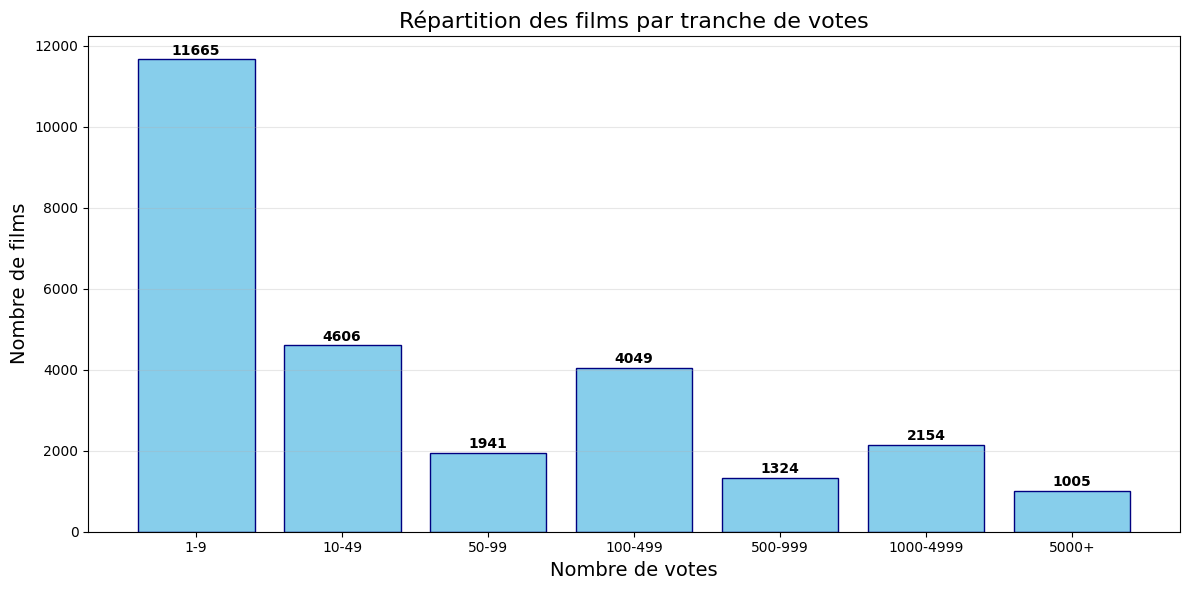

In [12]:
# Graphique à barres - répartition des films par tranche de votes
plt.figure(figsize=(12, 6))
plt.bar(labels, vote_counts, color='skyblue', edgecolor='navy')
plt.title('Répartition des films par tranche de votes', fontsize=16)
plt.xlabel('Nombre de votes', fontsize=14)
plt.ylabel('Nombre de films', fontsize=14)
plt.grid(axis='y', linestyle='-', alpha=0.3)

# Ajouter les valeurs sur chaque barre
for i, vote_count in enumerate(vote_counts):
    plt.text(i, vote_count + (max(vote_counts) * 0.01), str(vote_count), 
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

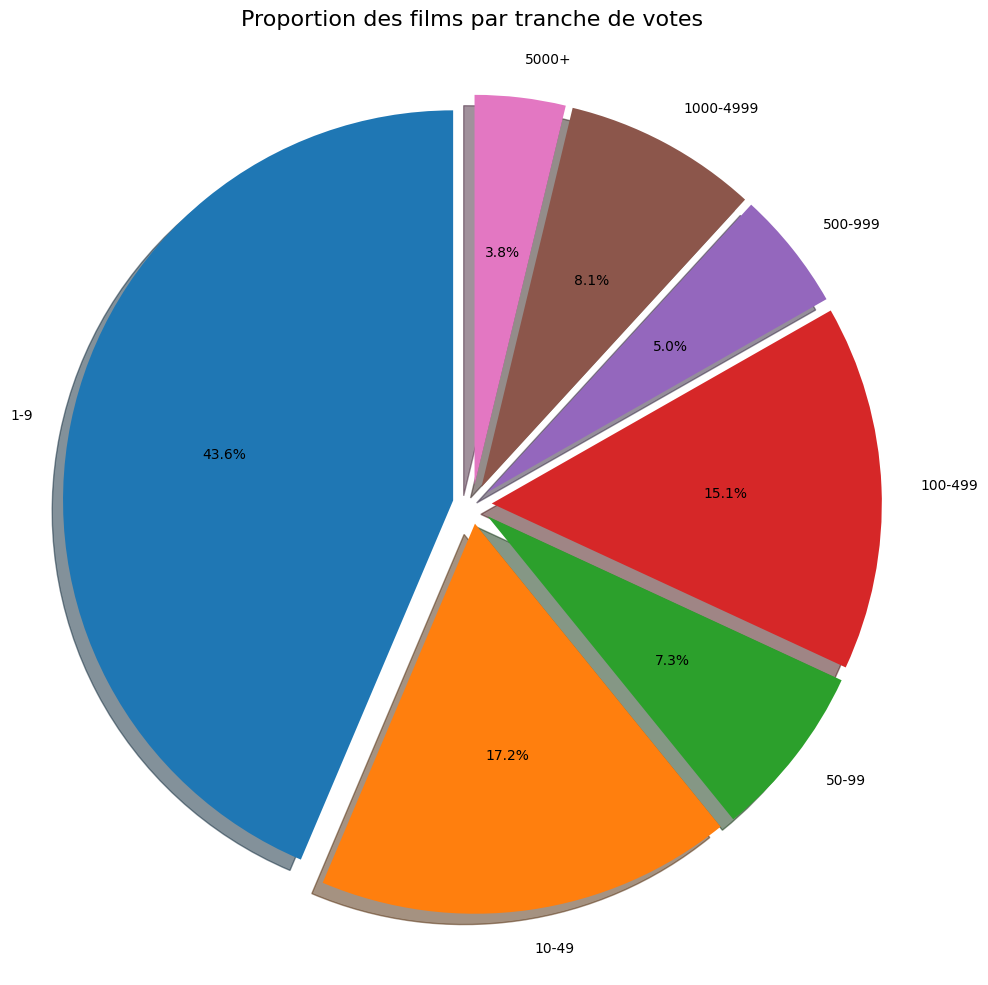

In [13]:
# Graphique en camembert - proportion des films par tranche de votes
plt.figure(figsize=(10, 10))
plt.pie(vote_counts, labels=labels, autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05] * len(labels))
plt.title('Proportion des films par tranche de votes', fontsize=16)
plt.axis('equal')  # Pour que le camembert soit circulaire
plt.tight_layout()
plt.show()

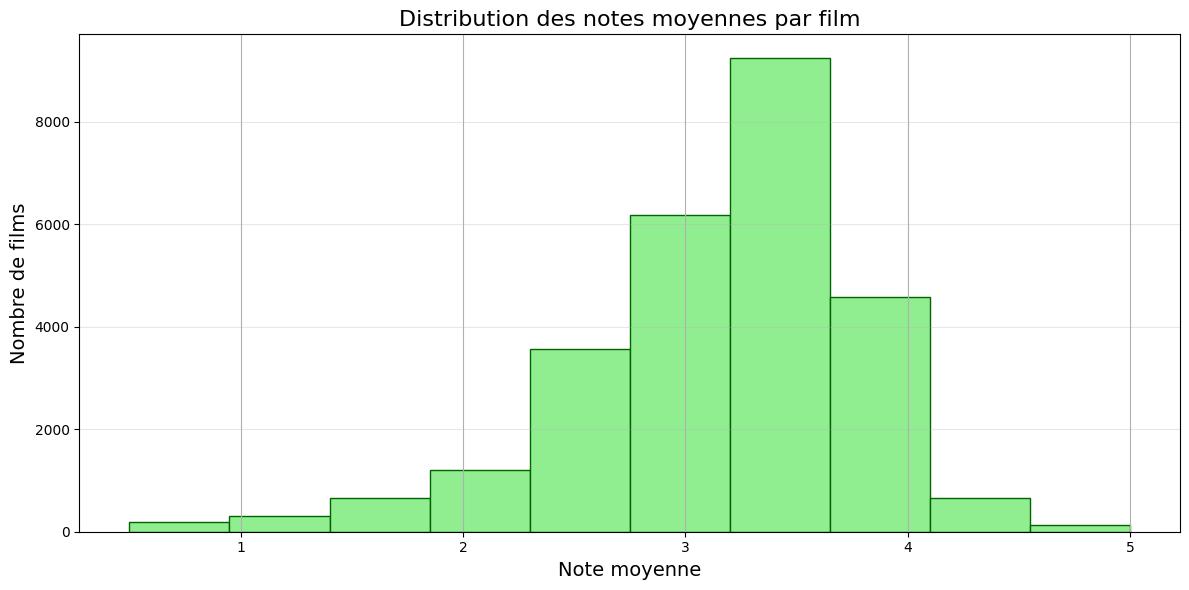

In [14]:
# Calcul des notes moyennes
avg_ratings = ratings_df.groupBy("movieId").agg(
    spark_round(avg("rating"), 1).alias("note_moyenne")
)

# Convertir en DataFrame pandas
avg_ratings_pd = avg_ratings.toPandas()

# Histogramme des notes moyennes
plt.figure(figsize=(12, 6))
avg_ratings_pd["note_moyenne"].hist(bins=10, color='lightgreen', edgecolor='darkgreen')
plt.title('Distribution des notes moyennes par film', fontsize=16)
plt.xlabel('Note moyenne', fontsize=14)
plt.ylabel('Nombre de films', fontsize=14)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

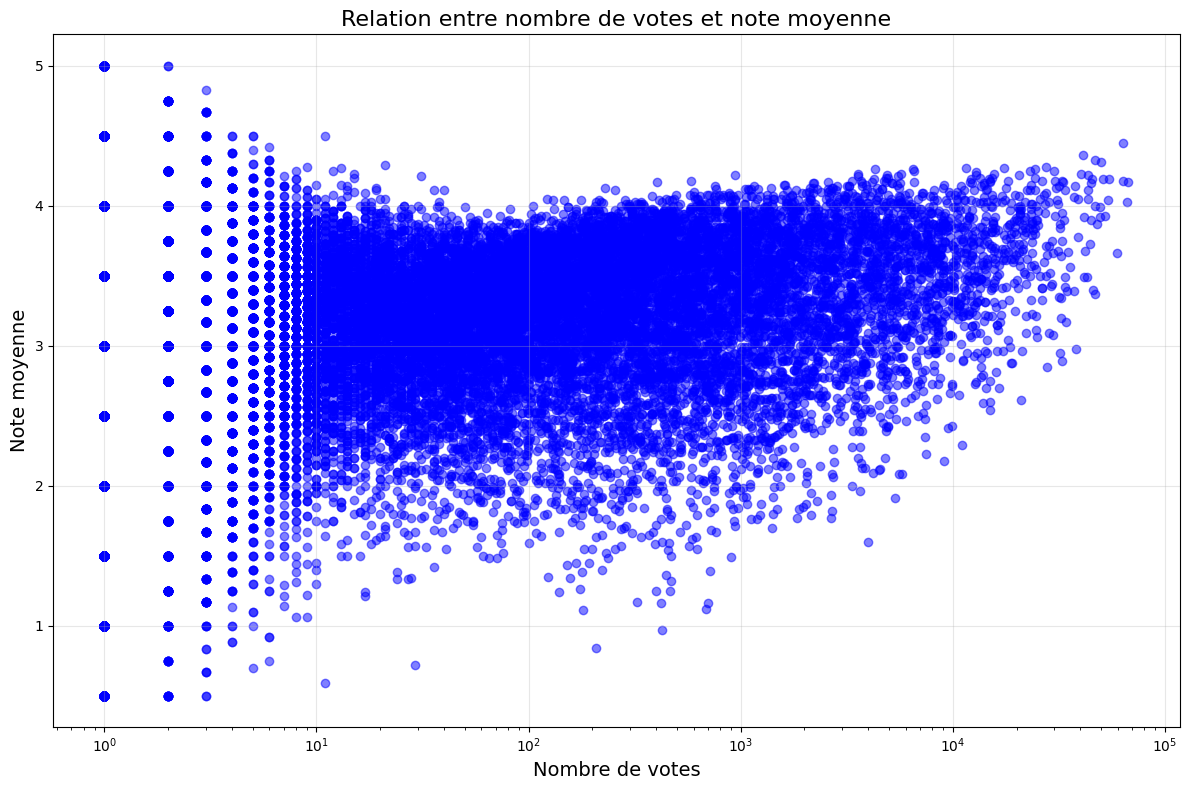

In [15]:
# Relation entre nombre de votes et note moyenne
movie_stats = ratings_df.groupBy("movieId").agg(
    sql_count("rating").alias("nombre_de_votes"),
    spark_round(avg("rating"), 2).alias("note_moyenne")
)

# Conversion en DataFrame pandas
movie_stats_pd = movie_stats.toPandas()

# Nuage de points
plt.figure(figsize=(12, 8))
plt.scatter(movie_stats_pd["nombre_de_votes"], movie_stats_pd["note_moyenne"], 
            alpha=0.5, color='blue')
plt.title('Relation entre nombre de votes et note moyenne', fontsize=16)
plt.xlabel('Nombre de votes', fontsize=14)
plt.ylabel('Note moyenne', fontsize=14)
plt.xscale('log')  # Échelle logarithmique
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
# Compter le nombre de votes par film
votes_per_movie = ratings_df.groupBy("movieId").agg(sql_count("*").alias("num_votes"))

# Sélectionner les films avec plus d'une note
movies_with_multiple_votes = votes_per_movie.filter(col("num_votes") > 1).select("movieId")

# Filtrer les notes pour ne conserver que celles des films avec plusieurs votes
filtered_ratings_df = ratings_df.join(movies_with_multiple_votes, on="movieId", how="inner")

# Filtrer les films pour ne conserver que ceux avec plusieurs votes
filtered_movies_df = movies_df.join(movies_with_multiple_votes, on="movieId", how="inner")


In [17]:
from pyspark.sql import functions as F

# 1. Compter le nombre total de films avant le filtrage
total_movies_before = movies_df.count()

# 2. Compter le nombre total de votes par film
votes_per_movie = ratings_df.groupBy("movieId").agg(F.count("*").alias("num_votes"))

# 3. Sélectionner les films avec plus d'une note
movies_with_multiple_votes = votes_per_movie.filter(F.col("num_votes") > 1)

# 4. Compter le nombre de films avec plus d'une note
total_movies_with_multiple_votes = movies_with_multiple_votes.count()

# 5. Filtrer les notes pour ne conserver que celles des films avec plusieurs votes
filtered_ratings_df = ratings_df.join(movies_with_multiple_votes, on="movieId", how="inner")

# 6. Filtrer les films pour ne conserver que ceux avec plusieurs votes
filtered_movies_df = movies_df.join(movies_with_multiple_votes, on="movieId", how="inner")

# 7. Calculer des statistiques supplémentaires
movie_stats = filtered_ratings_df.groupBy("movieId").agg(
    F.count("*").alias("num_votes"),
    F.min("rating").alias("min_rating"),
    F.max("rating").alias("max_rating"),
    F.round(F.avg("rating"), 2).alias("avg_rating")
)

# Joindre avec le DataFrame des films pour inclure le genre
movie_stats_with_genre = movie_stats.join(
    filtered_movies_df.select("movieId", "genres"),
    on="movieId",
    how="left"
)

# Afficher un aperçu des statistiques
movie_stats_with_genre.show(5, truncate=False)

# Sauvegarder le DataFrame dans HDFS
output_path = f"{hdfs_prefix}/output/movie_stats_filtered"
movie_stats_with_genre.write.mode("overwrite").option("header", "true").csv(output_path)

# Compter le nombre total d'éléments après le filtrage
total_count_after = movie_stats_with_genre.count()

# Calculer le nombre d'éléments retirés
removed_count = total_movies_before - total_movies_with_multiple_votes

# Afficher les statistiques
print(f"✔️ Nombre total de films avant le filtrage : {total_movies_before}")
print(f"✔️ Nombre de films avec plus d'une note : {total_movies_with_multiple_votes}")
print(f"✔️ Nombre de films retirés : {removed_count}")
print(f"✔️ Nombre total d'éléments après le filtrage : {total_count_after}")


+-------+---------+----------+----------+----------+-------------------------------+
|movieId|num_votes|min_rating|max_rating|avg_rating|genres                         |
+-------+---------+----------+----------+----------+-------------------------------+
|1580   |35580    |0.5       |5.0       |3.56      |Action|Comedy|Sci-Fi           |
|2366   |6627     |0.5       |5.0       |3.55      |Action|Adventure|Fantasy|Horror|
|3175   |13945    |0.5       |5.0       |3.6       |Adventure|Comedy|Sci-Fi        |
|3918   |1246     |0.5       |5.0       |2.92      |Horror                         |
|3997   |2047     |0.5       |5.0       |2.07      |Adventure|Fantasy              |
+-------+---------+----------+----------+----------+-------------------------------+
only showing top 5 rows



[Stage 177:==========================>                             (8 + 9) / 17]

✔️ Nombre total de films avant le filtrage : 27278
✔️ Nombre de films avec plus d'une note : 22772
✔️ Nombre de films retirés : 4506
✔️ Nombre total d'éléments après le filtrage : 22772


In [18]:
# Enregistrer les notes filtrées
filtered_ratings_df.write.option("header", True).mode("overwrite").csv("hdfs:///processed/rating.csv")

# Enregistrer les films filtrés
filtered_movies_df.write.option("header", True).mode("overwrite").csv("hdfs:///processed/movie.csv")


In [19]:
from pyspark.sql.functions import col, count as sql_count, min, max, avg, round as spark_round

# Calculer les statistiques des films
movie_stats = ratings_df.groupBy("movieId").agg(
    sql_count("rating").alias("nombre_de_votes"),
    min("rating").alias("vote_minimum"),
    max("rating").alias("vote_maximum"),
    spark_round(avg("rating"), 2).alias("moyenne_des_votes")
)

# Joindre avec le DataFrame des films pour inclure le genre
movie_stats_with_genre = movie_stats.join(
    movies_df.select("movieId", "genres"),  # Sélectionner uniquement les colonnes nécessaires
    on="movieId",
    how="left"
)

# Afficher un aperçu des statistiques
movie_stats_with_genre.show(5, truncate=False)

# Compter le nombre total d'éléments avant l'écriture
total_count = movie_stats_with_genre.count()
print(f"✔️ Nombre total d'éléments : {total_count}")

# Sauvegarder le DataFrame dans HDFS
# output_path = f"{hdfs_prefix}/output/movie_stats"
# movie_stats_with_genre.write.mode("overwrite").option("header", "true").csv(output_path)

print(f"✔️ Les statistiques des films ont été sauvegardées dans HDFS à l'emplacement : {output_path}")

+-------+---------------+------------+------------+-----------------+-------------------------------+
|movieId|nombre_de_votes|vote_minimum|vote_maximum|moyenne_des_votes|genres                         |
+-------+---------------+------------+------------+-----------------+-------------------------------+
|3997   |2047           |0.5         |5.0         |2.07             |Adventure|Fantasy              |
|1580   |35580          |0.5         |5.0         |3.56             |Action|Comedy|Sci-Fi           |
|3918   |1246           |0.5         |5.0         |2.92             |Horror                         |
|2366   |6627           |0.5         |5.0         |3.55             |Action|Adventure|Fantasy|Horror|
|3175   |13945          |0.5         |5.0         |3.6              |Adventure|Comedy|Sci-Fi        |
+-------+---------------+------------+------------+-----------------+-------------------------------+
only showing top 5 rows



[Stage 197:=============>                                         (4 + 12) / 16]

✔️ Nombre total d'éléments : 26744
✔️ Les statistiques des films ont été sauvegardées dans HDFS à l'emplacement : hdfs:////output/movie_stats_filtered
